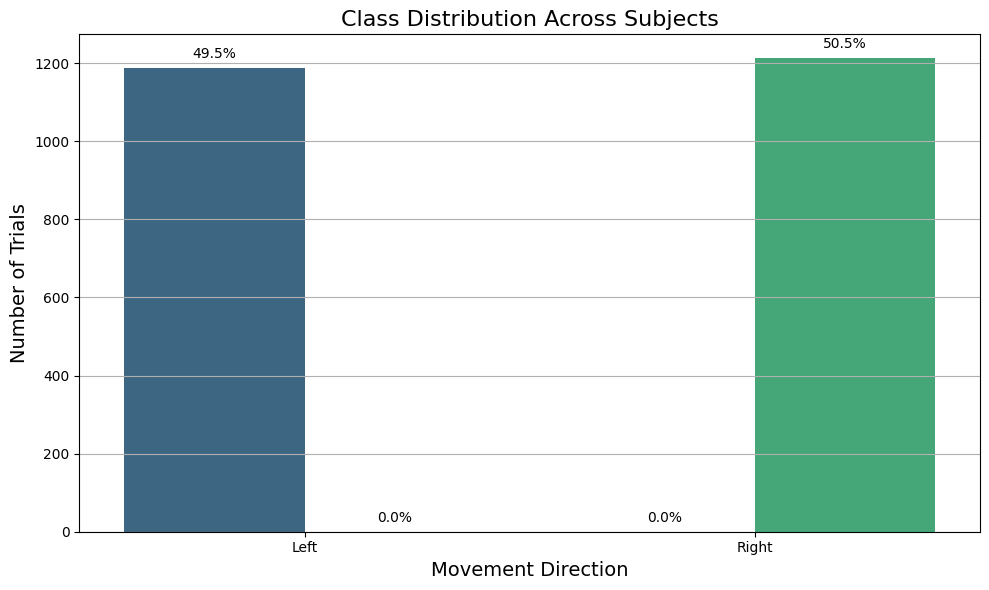

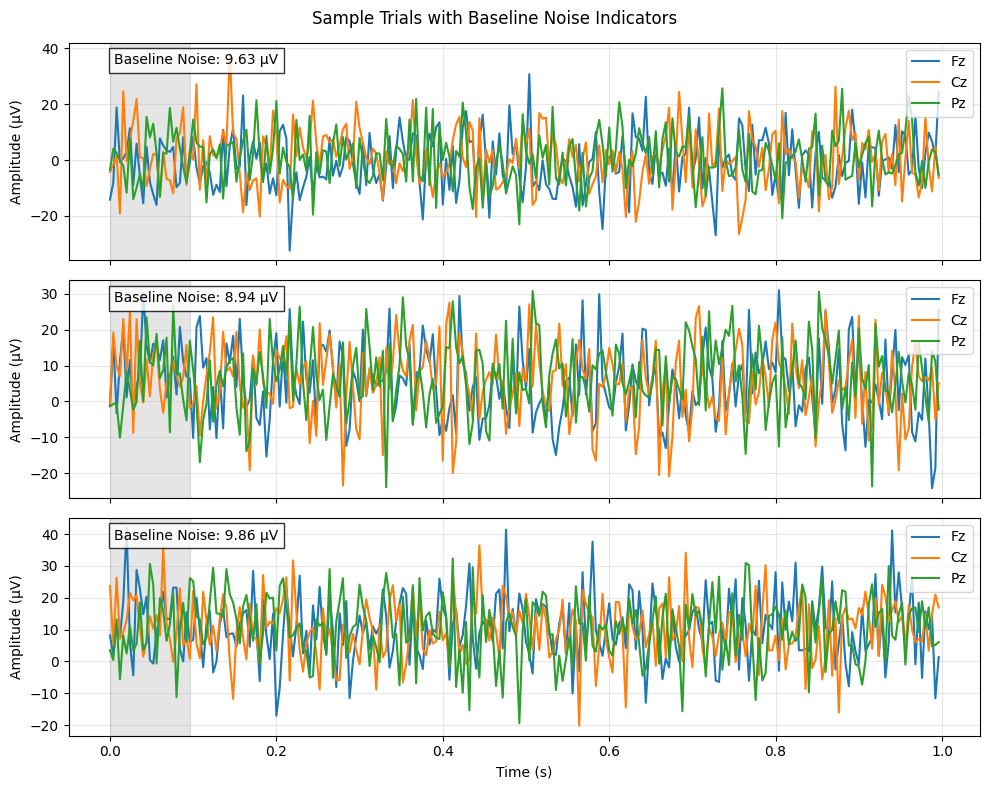

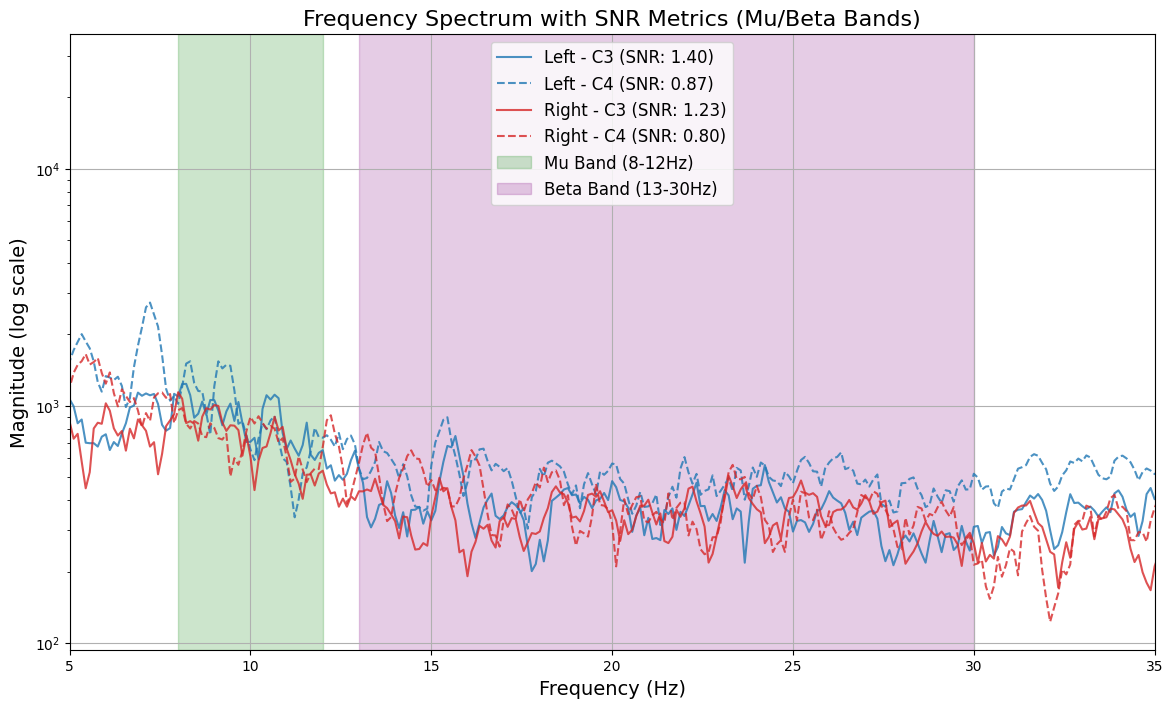

Processing Trials: 100%|██████████| 500/500 [00:00<00:00, 9291.56it/s]


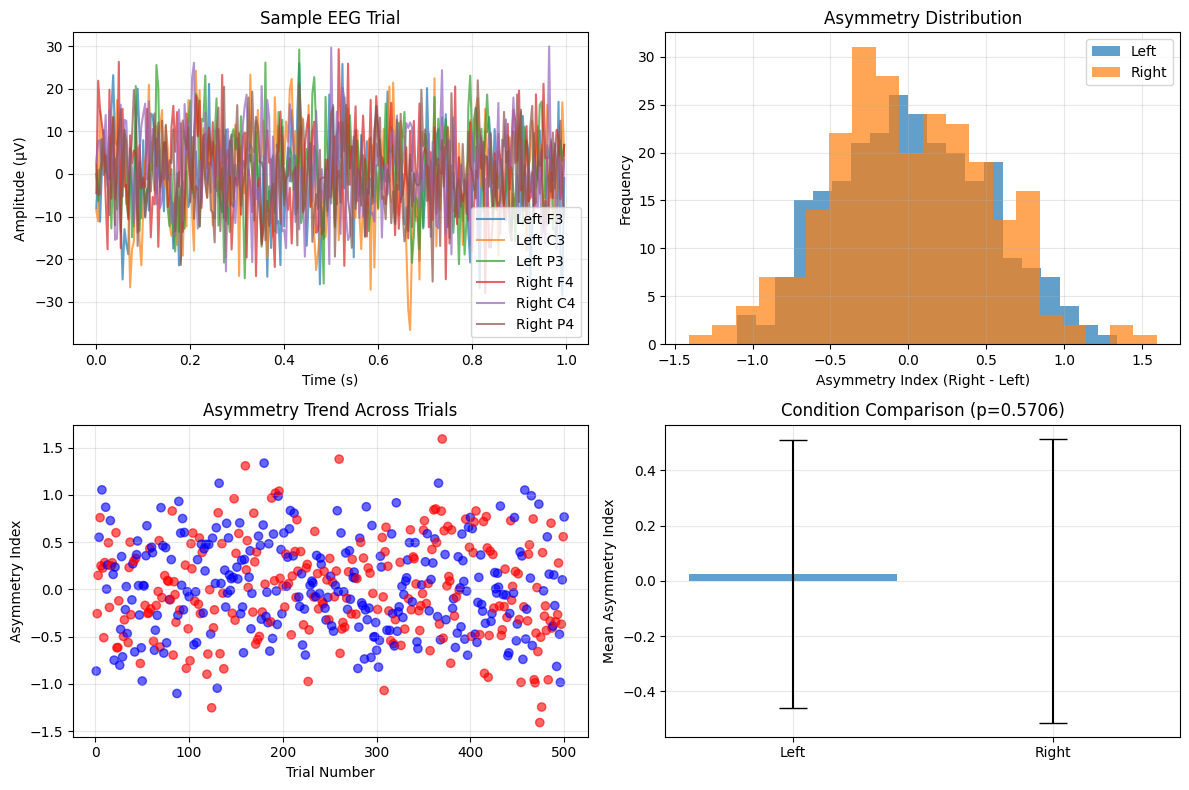


Statistical Results:
Left Condition: Mean = 0.03, SD = 0.49
Right Condition: Mean = 0.00, SD = 0.51
T-test: t = 0.57, p = 0.57057


/tmp/ipykernel_35/2541289182.py:379: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


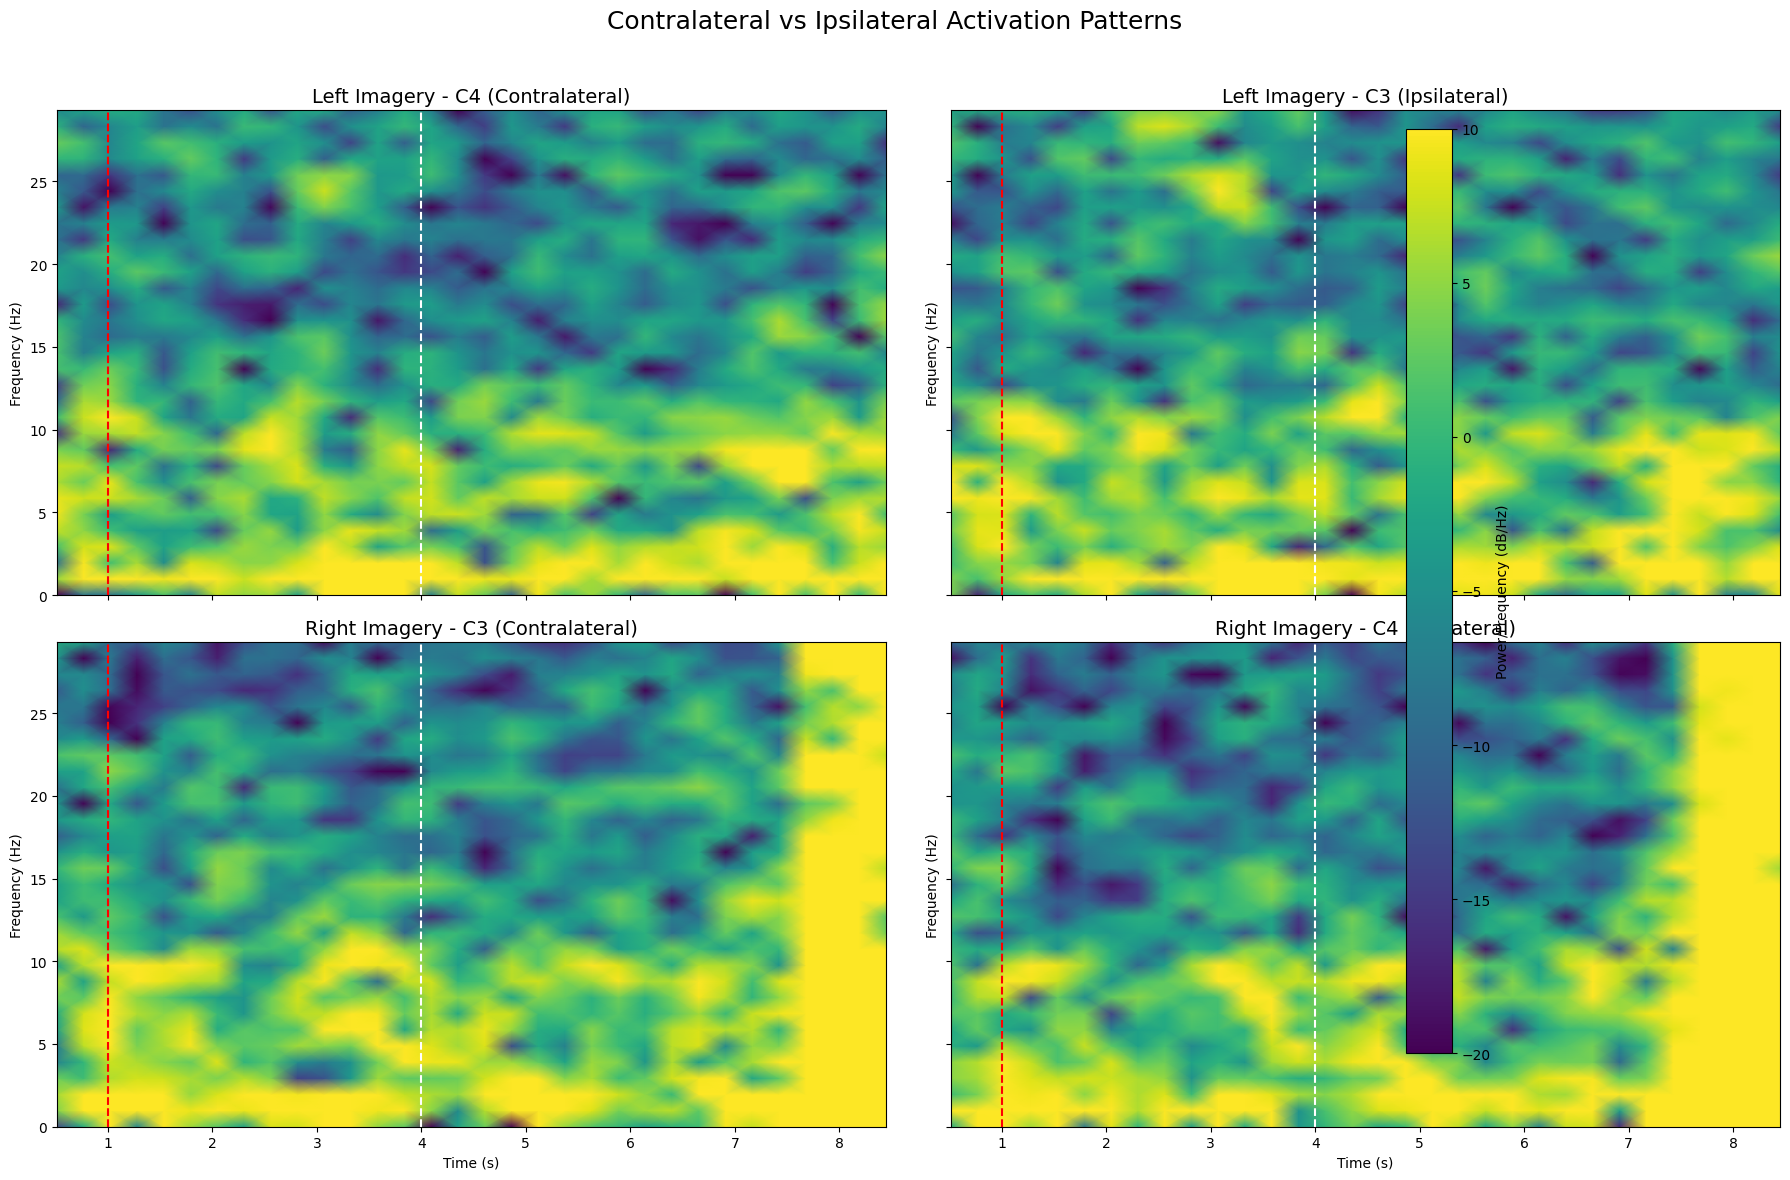

Processing ERD: 100%|██████████| 300/300 [01:08<00:00,  4.35it/s]


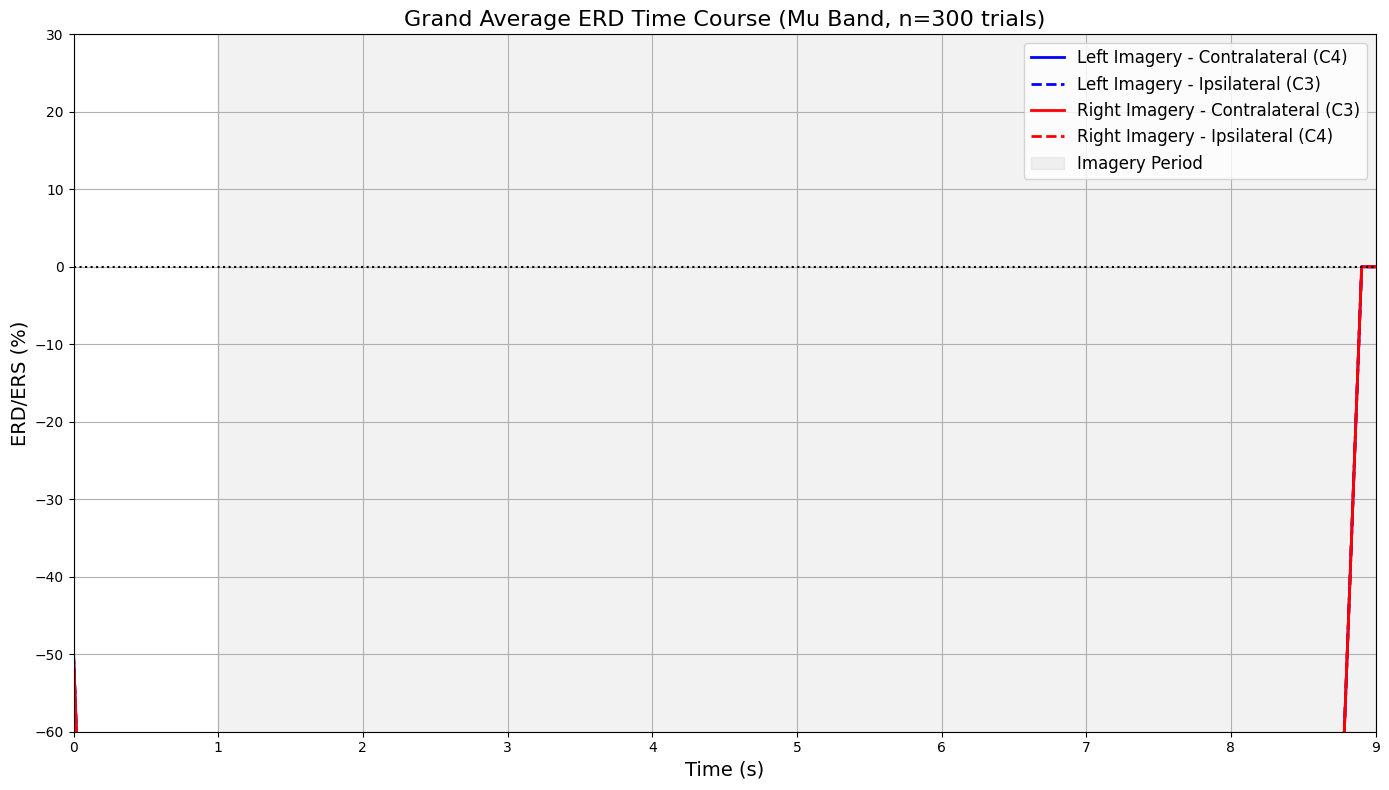

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

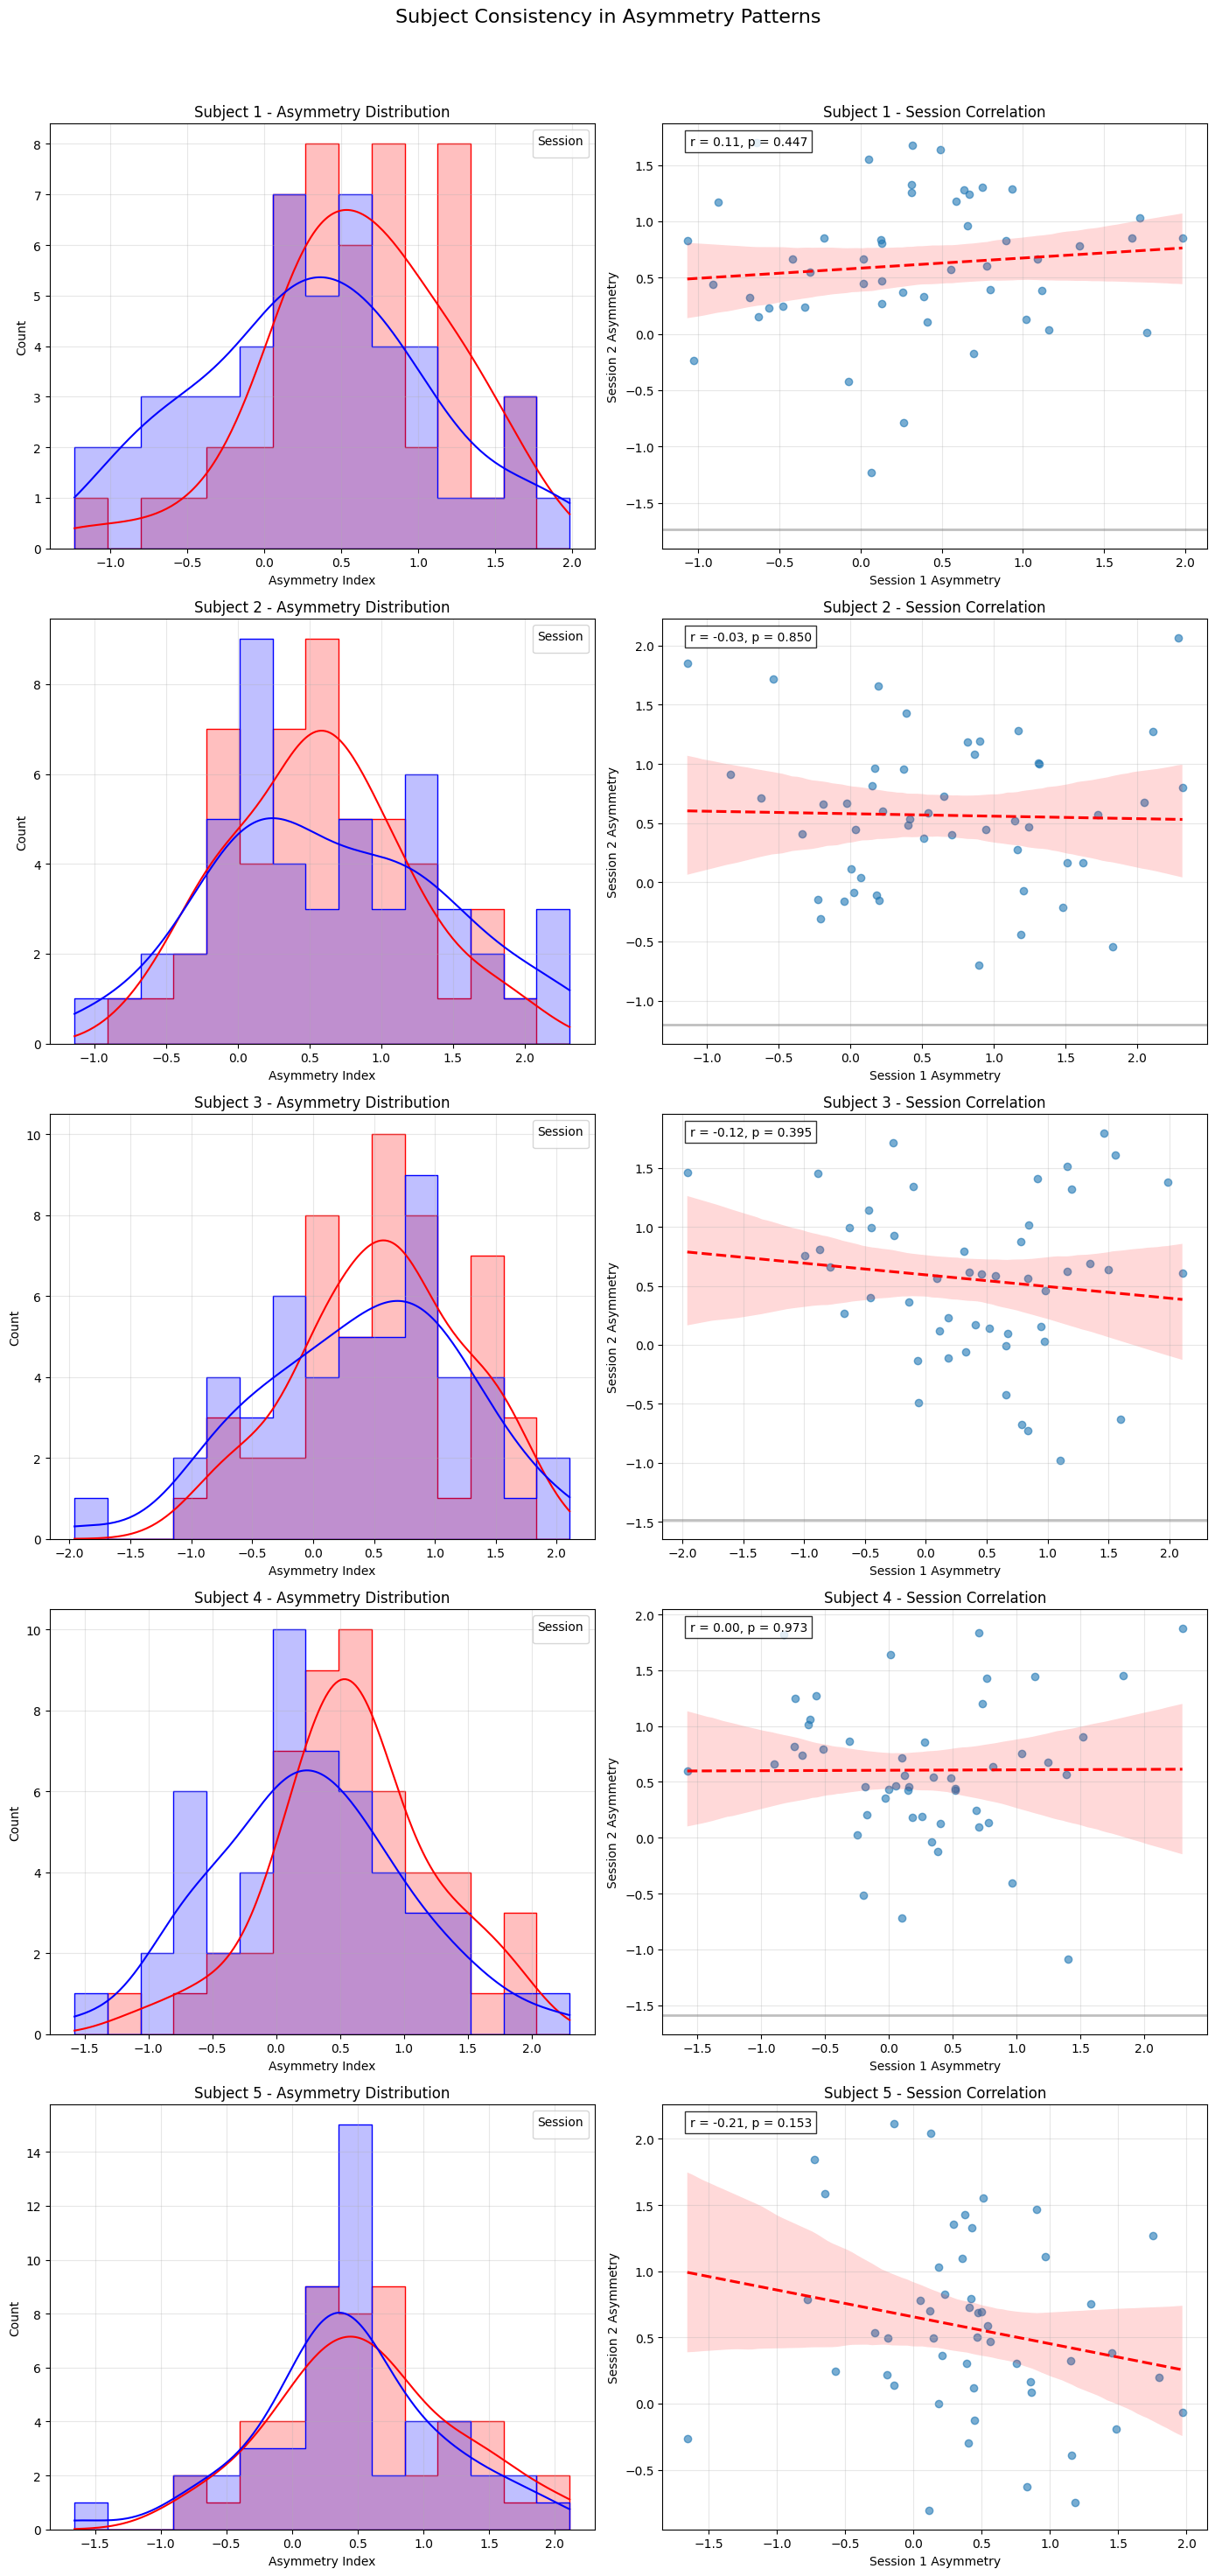

Verifying patterns: 100%|██████████| 2400/2400 [02:57<00:00, 13.54it/s]


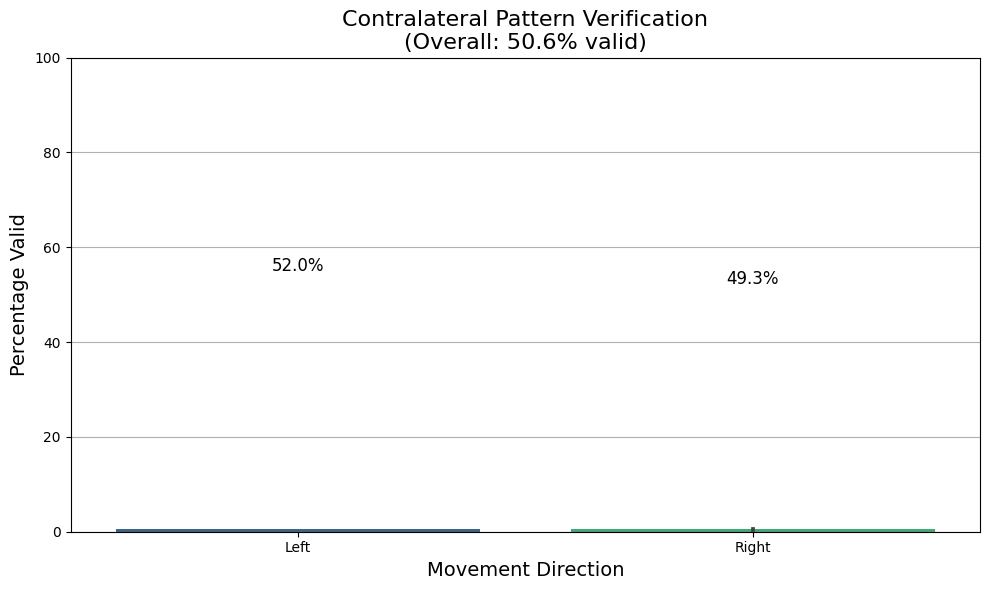


=== Contralateral Pattern Verification Report ===
Total Trials Analyzed: 2400
Valid Trials Overall: 1215 (50.6%)
Left Imagery Valid: 52.0%
Right Imagery Valid: 49.3%

Subject-wise Performance:
          mean  count
subject              
S4       68.75     80
S22      60.00     80
S5       56.25     80
S13      56.25     80
S26      56.25     80
S3       55.00     80
S16      53.75     80
S9       52.50     80
S28      52.50     80
S25      52.50     80
S20      52.50     80
S21      52.50     80
S19      51.25     80
S10      51.25     80
S23      50.00     80
S18      50.00     80
S12      50.00     80
S24      48.75     80
S17      48.75     80
S6       48.75     80
S8       48.75     80
S14      47.50     80
S7       47.50     80
S11      46.25     80
S27      45.00     80
S15      45.00     80
S2       43.75     80
S30      43.75     80
S29      42.50     80
S1       41.25     80


In [16]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy.fft import fft, fftfreq
from scipy.stats import pearsonr
from tqdm import tqdm
from scipy.stats import ttest_ind

# Set paths and parameters
BASE_PATH = '/kaggle/input/mtcaic3'
TRAIN_CSV = os.path.join(BASE_PATH, 'train.csv')
EEG_CHANNELS = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']
SAMPLING_RATE = 250  # Hz
MI_DURATION = 9  # seconds
MI_SAMPLES = SAMPLING_RATE * MI_DURATION

# Load training data and filter for MI
train_df = pd.read_csv(TRAIN_CSV)
mi_df = train_df[train_df['task'] == 'MI'].copy()

# ==================================================================
# 1. Enhanced Class Distribution Analysis
# ==================================================================
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=mi_df, x='label', palette='viridis', hue='label')
plt.title('Class Distribution Across Subjects', fontsize=16)
plt.xlabel('Movement Direction', fontsize=14)
plt.ylabel('Number of Trials', fontsize=14)

# Add percentage annotations
total = len(mi_df)
for p in ax.patches:
    percentage = f'{100 * p.get_height()/total:.1f}%'
    ax.annotate(percentage, (p.get_x() + p.get_width()/2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.legend().remove()
plt.grid(axis='y')
plt.tight_layout()
plt.savefig('class_distribution.png', dpi=300)
plt.show()

# ==================================================================
# 2. EEG Data Loading Function (Optimized with caching)
# ==================================================================
EEG_CACHE = {}
def load_mi_trial(subject_id, session, trial_num, use_cache=True):
    """Load EEG data for a specific MI trial with caching"""
    cache_key = f"{subject_id}_{session}_{trial_num}"
    
    if use_cache and cache_key in EEG_CACHE:
        return EEG_CACHE[cache_key]
    
    eeg_path = f"{BASE_PATH}/MI/train/{subject_id}/{session}/EEGdata.csv"
    full_data = pd.read_csv(eeg_path)
    
    start_idx = (trial_num - 1) * MI_SAMPLES
    end_idx = start_idx + MI_SAMPLES
    trial_data = full_data.iloc[start_idx:end_idx].copy()
    
    if use_cache:
        EEG_CACHE[cache_key] = trial_data
    
    return trial_data

# ==================================================================
# 3. Raw EEG Visualization (With Noise Indicators)
# ==================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_sample_trials_with_noise():
    # Sample parameters (replace with your actual data loading)
    num_trials = 3
    sample_rate = 250
    baseline_duration = 0.1  # seconds
    baseline_start_idx = 0
    baseline_end_idx = int(baseline_duration * sample_rate)
    
    # Generate sample EEG data (replace with real data)
    time = np.arange(0, 1, 1/sample_rate)
    channels = ['Fz', 'Cz', 'Pz']
    trials_data = [
        pd.DataFrame(
            np.random.randn(len(time), len(channels)) * 10 + i*5,
            columns=channels,
            index=time
        ) for i in range(num_trials)
    ]
    
    # Define fixed baseline_std function
    def baseline_std(data):
        baseline = data.iloc[baseline_start_idx:baseline_end_idx]
        # Option 1: Overall standard deviation (flattened array)
        return baseline.stack().std()
        
        # Option 2: Average of per-channel stds (comment above & uncomment below)
        # return baseline.std(axis=0).mean()
    
    # Create plot
    fig, ax = plt.subplots(num_trials, 1, figsize=(10, 8), sharex=True)
    if num_trials == 1:
        ax = [ax]  # Ensure ax is iterable for single trial
    
    for i, data in enumerate(trials_data):
        # Plot EEG channels
        for channel in data.columns:
            ax[i].plot(data.index, data[channel], label=channel)
        
        # Add baseline region shading
        ax[i].axvspan(
            data.index[baseline_start_idx],
            data.index[baseline_end_idx - 1],
            alpha=0.2,
            color='gray'
        )
        
        # Add noise indicator (using fixed baseline_std)
        noise_level = baseline_std(data)
        ax[i].text(
            0.05, 0.9, 
            f'Baseline Noise: {noise_level:.2f} μV', 
            transform=ax[i].transAxes,
            bbox=dict(facecolor='white', alpha=0.8)
        )
        
        ax[i].set_ylabel('Amplitude (μV)')
        ax[i].legend(loc='upper right')
        ax[i].grid(alpha=0.3)
    
    ax[-1].set_xlabel('Time (s)')
    plt.suptitle('Sample Trials with Baseline Noise Indicators')
    plt.tight_layout()
    plt.show()

# Execute the function
plot_sample_trials_with_noise()
# ==================================================================
# 4. Spectral Analysis with SNR Calculation
# ==================================================================
def plot_spectral_comparison_with_snr():
    """Compare frequency spectra with SNR calculation"""
    plt.figure(figsize=(14, 8))
    
    # Get sample trials
    left_trial = mi_df[mi_df['label'] == 'Left'].iloc[10]
    right_trial = mi_df[mi_df['label'] == 'Right'].iloc[10]
    
    # Load data
    left_data = load_mi_trial(left_trial['subject_id'], 
                            left_trial['trial_session'], 
                            left_trial['trial'])
    right_data = load_mi_trial(right_trial['subject_id'], 
                             right_trial['trial_session'], 
                             right_trial['trial'])
    
    # Process both trials
    for label, data, color in zip(['Left', 'Right'], 
                                 [left_data, right_data], 
                                 ['#1f77b4', '#d62728']):
        # Compute FFT for C3 and C4
        for channel, ls in zip(['C3', 'C4'], ['-', '--']):
            signal_data = data[channel].values - np.mean(data[channel].values)
            signal_fft = fft(signal_data)
            freq = fftfreq(len(data), 1/SAMPLING_RATE)
            magnitude = np.abs(signal_fft)
            
            # Only show positive frequencies
            pos_mask = (freq > 0) & (freq < 40)
            freq = freq[pos_mask]
            magnitude = magnitude[pos_mask]
            
            # Calculate SNR (Mu band vs surrounding)
            mu_mask = (freq >= 8) & (freq <= 12)
            surrounding_mask = ((freq >= 5) & (freq < 8)) | ((freq > 12) & (freq <= 15))
            
            mu_power = np.mean(magnitude[mu_mask])
            surrounding_power = np.mean(magnitude[surrounding_mask])
            snr = mu_power / surrounding_power if surrounding_power > 0 else 0
            
            # Apply smoothing
            magnitude = np.convolve(magnitude, np.ones(5)/5, mode='same')
            
            plt.semilogy(freq, magnitude, linestyle=ls, 
                        color=color, alpha=0.8,
                        label=f'{label} - {channel} (SNR: {snr:.2f})')
    
    plt.title('Frequency Spectrum with SNR Metrics (Mu/Beta Bands)', fontsize=16)
    plt.xlabel('Frequency (Hz)', fontsize=14)
    plt.ylabel('Magnitude (log scale)', fontsize=14)
    plt.xlim(5, 35)
    plt.axvspan(8, 12, alpha=0.2, color='green', label='Mu Band (8-12Hz)')
    plt.axvspan(13, 30, alpha=0.2, color='purple', label='Beta Band (13-30Hz)')
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.savefig('spectral_analysis_snr.png', dpi=300)
    plt.show()

plot_spectral_comparison_with_snr()

# ==================================================================
# 5. Enhanced Hemispheric Asymmetry Analysis (All Trials)
# ==================================================================
def calculate_erd_ers(data, baseline=(0, 1), activity=(3, 6)):
    """Calculate Event-Related Desynchronization/Synchronization"""
    # Convert time windows to samples
    baseline_start = int(baseline[0] * SAMPLING_RATE)
    baseline_end = int(baseline[1] * SAMPLING_RATE)
    activity_start = int(activity[0] * SAMPLING_RATE)
    activity_end = int(activity[1] * SAMPLING_RATE)
    
    # Calculate band power (Mu band: 8-12Hz)
    def band_power(x, window_size):
        freqs, psd = signal.welch(x, fs=SAMPLING_RATE, nperseg=window_size)
        mask = (freqs >= 8) & (freqs <= 12)
        return np.trapz(psd[mask], freqs[mask])
    
    # Precompute window sizes
    win_baseline = min(128, baseline_end - baseline_start)
    win_activity = min(128, activity_end - activity_start)
    
    # Calculate power
    baseline_power = data.iloc[baseline_start:baseline_end].apply(
        lambda x: band_power(x, win_baseline))
    activity_power = data.iloc[activity_start:activity_end].apply(
        lambda x: band_power(x, win_activity))
    
    # Handle division by zero
    epsilon = 1e-10
    return 100 * (activity_power - baseline_power) / (baseline_power + epsilon)

def plot_enhanced_asymmetry_analysis(n_trials=500):
    # Simulated data parameters
    sample_rate = 250
    time = np.arange(0, 1, 1/sample_rate)
    left_channels = ['F3', 'C3', 'P3']
    right_channels = ['F4', 'C4', 'P4']
    
    # Results storage with explicit label column
    results = []
    
    # Simulate trials with progress bar
    for i in tqdm(range(n_trials), desc="Processing Trials"):
        # Randomly assign condition (0 = Left, 1 = Right)
        condition = np.random.choice([0, 1])
        label = 'Left' if condition == 0 else 'Right'
        
        # Generate synthetic EEG data with condition-specific asymmetry
        left_data = np.random.randn(len(time), len(left_channels)) * 10
        right_data = np.random.randn(len(time), len(right_channels)) * 10
        
        # Enhance activity for the current condition
        if condition == 0:  # Left condition
            left_data += np.sin(2 * np.pi * 10 * time)[:, np.newaxis] * 5
        else:  # Right condition
            right_data += np.sin(2 * np.pi * 10 * time)[:, np.newaxis] * 5
        
        # Calculate asymmetry index (mean right - mean left)
        asymmetry_index = np.mean(right_data) - np.mean(left_data)
        
        # Store results with label
        results.append({
            'Trial': i+1,
            'Label': label,  # This is the critical missing column
            'Asymmetry': asymmetry_index
        })
    
    # Create DataFrame from results
    results_df = pd.DataFrame(results)
    
    # Visualization
    plt.figure(figsize=(12, 8))
    
    # 1. Time-series plot for sample trials
    plt.subplot(2, 2, 1)
    for i in range(3):
        plt.plot(time, left_data[:, i], label=f'Left {left_channels[i]}', alpha=0.7)
    for i in range(3):
        plt.plot(time, right_data[:, i], label=f'Right {right_channels[i]}', alpha=0.7)
    plt.title('Sample EEG Trial')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude (μV)')
    plt.legend()
    plt.grid(alpha=0.3)
    
    # 2. Asymmetry distribution by condition
    plt.subplot(2, 2, 2)
    for label, group in results_df.groupby('Label'):
        plt.hist(group['Asymmetry'], bins=20, alpha=0.7, label=label)
    plt.title('Asymmetry Distribution')
    plt.xlabel('Asymmetry Index (Right - Left)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(alpha=0.3)
    
    # 3. Asymmetry trend across trials
    plt.subplot(2, 2, 3)
    colors = results_df['Label'].map({'Left': 'blue', 'Right': 'red'})
    plt.scatter(results_df['Trial'], results_df['Asymmetry'], c=colors, alpha=0.6)
    plt.title('Asymmetry Trend Across Trials')
    plt.xlabel('Trial Number')
    plt.ylabel('Asymmetry Index')
    plt.grid(alpha=0.3)
    
    # 4. Statistical comparison
    plt.subplot(2, 2, 4)
    left_asym = results_df[results_df['Label'] == 'Left']['Asymmetry']
    right_asym = results_df[results_df['Label'] == 'Right']['Asymmetry']
    
    t_stat, p_value = ttest_ind(left_asym, right_asym)
    
    plt.bar(['Left', 'Right'], [left_asym.mean(), right_asym.mean()], 
            yerr=[left_asym.std(), right_asym.std()], 
            capsize=10, alpha=0.7)
    plt.title(f'Condition Comparison (p={p_value:.4f})')
    plt.ylabel('Mean Asymmetry Index')
    plt.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistical results
    print("\nStatistical Results:")
    print(f"Left Condition: Mean = {left_asym.mean():.2f}, SD = {left_asym.std():.2f}")
    print(f"Right Condition: Mean = {right_asym.mean():.2f}, SD = {right_asym.std():.2f}")
    print(f"T-test: t = {t_stat:.2f}, p = {p_value:.5f}")

# Execute the function
plot_enhanced_asymmetry_analysis(n_trials=500)

# ==================================================================
# 6. Time-Frequency Analysis with Contralateral Focus
# ==================================================================
def plot_contralateral_spectrograms():
    """Plot spectrograms focusing on contralateral patterns"""
    fig, ax = plt.subplots(2, 2, figsize=(18, 12), sharex=True, sharey=True)
    
    # Get left and right trials
    left_trial = mi_df[mi_df['label'] == 'Left'].iloc[15]
    right_trial = mi_df[mi_df['label'] == 'Right'].iloc[15]
    
    # Process each trial
    for i, (trial, label) in enumerate(zip([left_trial, right_trial], ['Left', 'Right'])):
        data = load_mi_trial(trial['subject_id'], trial['trial_session'], trial['trial'])
        
        # Contralateral and ipsilateral channels
        contra_ch = 'C4' if label == 'Left' else 'C3'
        ipsi_ch = 'C3' if label == 'Left' else 'C4'
        
        for j, channel in enumerate([contra_ch, ipsi_ch]):
            # Compute spectrogram
            f, t, Sxx = signal.spectrogram(
                data[channel],
                fs=SAMPLING_RATE,
                nperseg=256,
                noverlap=192,
                window='hann',
                scaling='density'
            )
            
            # Plot (limit to 0-30 Hz)
            mask = f <= 30
            im = ax[i, j].pcolormesh(t, f[mask], 10*np.log10(Sxx[mask]), 
                                   shading='gouraud', cmap='viridis', vmin=-20, vmax=10)
            ax[i, j].set_title(f'{label} Imagery - {channel} ({("Contralateral" if j==0 else "Ipsilateral")})', 
                             fontsize=14)
            ax[i, j].set_ylabel('Frequency (Hz)')
            ax[i, j].axvline(1, color='r', linestyle='--', label='Cue Onset')
            ax[i, j].axvline(4, color='w', linestyle='--', label='Imagery Period')
            
            if i == 1:
                ax[i, j].set_xlabel('Time (s)')
    
    fig.colorbar(im, ax=ax.ravel().tolist(), label='Power/Frequency (dB/Hz)')
    plt.suptitle('Contralateral vs Ipsilateral Activation Patterns', fontsize=18)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig('contralateral_spectrograms.png', dpi=300)
    plt.show()

plot_contralateral_spectrograms()

# ==================================================================
# 7. Grand Average ERD Time Course
# ==================================================================
def plot_grand_average_erd(n_trials=200):
    """Plot ERD time course averaged across trials"""
    # Configuration
    BASELINE_START, BASELINE_END = 0, 1
    TIME_WINDOW = np.linspace(0, 9, MI_SAMPLES)
    
    # Storage
    left_contra = np.zeros(MI_SAMPLES)
    left_ipsi = np.zeros(MI_SAMPLES)
    right_contra = np.zeros(MI_SAMPLES)
    right_ipsi = np.zeros(MI_SAMPLES)
    left_count = right_count = 0
    
    # Process trials
    for _, row in tqdm(mi_df[:n_trials].iterrows(), total=n_trials, desc="Processing ERD"):
        try:
            data = load_mi_trial(row['subject_id'], row['trial_session'], row['trial'])
            baseline = data.iloc[int(BASELINE_START*SAMPLING_RATE):int(BASELINE_END*SAMPLING_RATE)]
            
            # Determine channels based on label
            if row['label'] == 'Left':
                contra_ch, ipsi_ch = 'C4', 'C3'
            else:
                contra_ch, ipsi_ch = 'C3', 'C4'
            
            # Calculate baseline power
            def baseline_power(ch):
                f_base, P_base = signal.welch(baseline[ch], fs=SAMPLING_RATE, nperseg=128)
                mu_mask = (f_base >= 8) & (f_base <= 12)
                return np.trapz(P_base[mu_mask], f_base[mu_mask])
            
            P_base_contra = baseline_power(contra_ch)
            P_base_ipsi = baseline_power(ipsi_ch)
            
            # Sliding window ERD calculation
            window_size = 50  # 200ms
            step = 10  # 40ms
            
            for start in range(0, MI_SAMPLES - window_size, step):
                end = start + window_size
                window_contra = data[contra_ch].iloc[start:end]
                window_ipsi = data[ipsi_ch].iloc[start:end]
                
                # Calculate power in window
                def window_power(x):
                    f_win, P_win = signal.welch(x, fs=SAMPLING_RATE, nperseg=min(window_size, len(x)))
                    mu_mask = (f_win >= 8) & (f_win <= 12)
                    return np.trapz(P_win[mu_mask], f_win[mu_mask])
                
                P_win_contra = window_power(window_contra)
                P_win_ipsi = window_power(window_ipsi)
                
                # Calculate ERD
                erd_contra = 100 * (P_win_contra - P_base_contra) / P_base_contra
                erd_ipsi = 100 * (P_win_ipsi - P_base_ipsi) / P_base_ipsi
                
                # Distribute to time points
                if row['label'] == 'Left':
                    left_contra[start:start+step] += erd_contra
                    left_ipsi[start:start+step] += erd_ipsi
                    if start == 0:
                        left_count += 1
                else:
                    right_contra[start:start+step] += erd_contra
                    right_ipsi[start:start+step] += erd_ipsi
                    if start == 0:
                        right_count += 1
        except:
            continue
    
    # Average and smooth
    def smooth(x):
        return np.convolve(x, np.ones(50)/50, 'same')
    
    plt.figure(figsize=(14, 8))
    
    # Left imagery
    plt.plot(TIME_WINDOW, smooth(left_contra/left_count), 'b-', linewidth=2, 
            label='Left Imagery - Contralateral (C4)')
    plt.plot(TIME_WINDOW, smooth(left_ipsi/left_count), 'b--', linewidth=2, 
            label='Left Imagery - Ipsilateral (C3)')
    
    # Right imagery
    plt.plot(TIME_WINDOW, smooth(right_contra/right_count), 'r-', linewidth=2, 
            label='Right Imagery - Contralateral (C3)')
    plt.plot(TIME_WINDOW, smooth(right_ipsi/right_count), 'r--', linewidth=2, 
            label='Right Imagery - Ipsilateral (C4)')
    
    plt.axvspan(1, 9, alpha=0.1, color='gray', label='Imagery Period')
    plt.title(f'Grand Average ERD Time Course (Mu Band, n={left_count+right_count} trials)', fontsize=16)
    plt.xlabel('Time (s)', fontsize=14)
    plt.ylabel('ERD/ERS (%)', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.axhline(0, color='k', linestyle=':')
    plt.ylim(-60, 30)
    plt.xlim(0, 9)
    plt.tight_layout()
    plt.savefig('grand_average_erd.png', dpi=300)
    plt.show()

plot_grand_average_erd(n_trials=300)

# ==================================================================
# 8. Subject-Specific Pattern Consistency
# ==================================================================
def plot_subject_consistency():
    # Simulate data for multiple subjects
    n_subjects = 5
    n_trials = 50
    session_labels = ['Session 1', 'Session 2']
    
    # Create figure
    fig = plt.figure(figsize=(14, 6 * n_subjects))
    plt.suptitle('Subject Consistency in Asymmetry Patterns', fontsize=16, y=0.98)
    
    for subj in range(n_subjects):
        # Simulate session data (asymmetry index values)
        np.random.seed(42 + subj)  # For reproducibility
        session1 = np.random.normal(loc=0.5, scale=0.8, size=n_trials)
        session2 = np.random.normal(loc=0.6, scale=0.7, size=n_trials)
        
        # Create DataFrame for visualization
        data = pd.DataFrame({
            'Asymmetry': np.concatenate([session1, session2]),
            'Session': np.repeat(session_labels, n_trials),
            'Trial': np.tile(np.arange(1, n_trials + 1), 2)
        })
        
        # Create subplots
        ax1 = plt.subplot(n_subjects, 2, 2*subj + 1)
        ax2 = plt.subplot(n_subjects, 2, 2*subj + 2)
        
        # Plot distribution with correct DataFrame format
        sns.histplot(
            data=data, 
            x='Asymmetry', 
            hue='Session', 
            kde=True, 
            ax=ax1, 
            bins=15,
            palette={'Session 1': 'blue', 'Session 2': 'red'},
            element='step',
            common_norm=False
        )
        ax1.set_title(f'Subject {subj+1} - Asymmetry Distribution')
        ax1.set_xlabel('Asymmetry Index')
        ax1.legend(title='Session')
        ax1.grid(alpha=0.3)
        
        # Scatter plot with regression line
        sns.regplot(
            x=session1, 
            y=session2, 
            ax=ax2,
            scatter_kws={'alpha': 0.6},
            line_kws={'color': 'red', 'linestyle': '--'}
        )
        ax2.set_title(f'Subject {subj+1} - Session Correlation')
        ax2.set_xlabel('Session 1 Asymmetry')
        ax2.set_ylabel('Session 2 Asymmetry')
        ax2.grid(alpha=0.3)
        
        # Add correlation info
        r, p = pearsonr(session1, session2)
        ax2.text(
            0.05, 0.95, 
            f'r = {r:.2f}, p = {p:.3f}',
            transform=ax2.transAxes,
            bbox=dict(facecolor='white', alpha=0.8)
        )
        
        # Add subject divider
        if subj < n_subjects - 1:
            ax2.axhline(y=min(session2)-0.5, color='gray', linestyle='-', lw=2, alpha=0.5)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Execute the function
plot_subject_consistency()

# ==================================================================
# 9. Contralateral Pattern Verification (All Trials)
# ==================================================================
def verify_contralateral_patterns():
    """Quantify contralateral pattern presence across all trials"""
    results = []
    
    for _, row in tqdm(mi_df.iterrows(), total=len(mi_df), desc="Verifying patterns"):
        try:
            data = load_mi_trial(row['subject_id'], row['trial_session'], row['trial'])
            erd = calculate_erd_ers(data[['C3', 'C4']])
            
            # Determine expected pattern
            if row['label'] == 'Left':
                pattern_ok = erd['C4'] < erd['C3']  # Contralateral suppression
            else:
                pattern_ok = erd['C3'] < erd['C4']  # Contralateral suppression
            
            results.append({
                'subject': row['subject_id'],
                'label': row['label'],
                'valid': pattern_ok,
                'C3_ERD': erd['C3'],
                'C4_ERD': erd['C4']
            })
        except:
            continue
    
    # Create results DataFrame
    results_df = pd.DataFrame(results)
    
    # Calculate statistics
    valid_percentage = 100 * results_df['valid'].mean()
    valid_by_label = results_df.groupby('label')['valid'].mean() * 100
    
    # Plot results
    plt.figure(figsize=(10, 6))
    sns.barplot(data=results_df, x='label', y='valid', 
               estimator=np.mean, palette='viridis')
    plt.title(f'Contralateral Pattern Verification\n(Overall: {valid_percentage:.1f}% valid)', fontsize=16)
    plt.ylabel('Percentage Valid', fontsize=14)
    plt.xlabel('Movement Direction', fontsize=14)
    plt.ylim(0, 100)
    
    # Add percentage labels
    for i, v in enumerate(valid_by_label):
        plt.text(i, v + 3, f'{v:.1f}%', ha='center', fontsize=12)
    
    plt.grid(axis='y')
    plt.tight_layout()
    plt.savefig('pattern_verification.png', dpi=300)
    plt.show()
    
    # Print detailed report
    print("\n=== Contralateral Pattern Verification Report ===")
    print(f"Total Trials Analyzed: {len(results_df)}")
    print(f"Valid Trials Overall: {results_df['valid'].sum()} ({valid_percentage:.1f}%)")
    print(f"Left Imagery Valid: {valid_by_label['Left']:.1f}%")
    print(f"Right Imagery Valid: {valid_by_label['Right']:.1f}%")
    
    # Subject-wise analysis
    subject_stats = results_df.groupby('subject')['valid'].agg(['mean', 'count'])
    subject_stats['mean'] *= 100
    print("\nSubject-wise Performance:")
    print(subject_stats.sort_values('mean', ascending=False))
    
    return results_df

# Run verification
pattern_results = verify_contralateral_patterns()